# Mejorar un modelo de machine learning

Una de las cosas más importantes al comparar diferentes modelos es asegurarse de que se comparen en las mismas divisiones de datos.

Por ejemplo, tenemos `model_1` y `model_2`, que difieren ligeramente.

Si queremos comparar y evaluar sus resultados, `model_1` y `model_2` deben ser entrenados en los mismos datos (`X_train` y `y_train`) y sus predicciones deben realizarse en los mismos datos, por ejemplo:

- `model_1.fit(X_train, y_train) -> model_1.predict(X_test) -> model_1_preds`
- `model_2.fit(X_train, y_train) -> model_2.predict(X_test) -> model_2_preds`

Este notebook compara 3 modelos diferentes usando el conjunto de datos de enfermedades cardíacas:

- Un `RandomForestClassifier` base (con todos los parámetros predeterminados)  
- Un `RandomForestClassifier` ajustado con `RandomizedSearchCV`. 
- Un `RandomForestClassifier` ajustado con `GridSearchCV`.

Lo más importante es que todos usan las mismas divisiones de datos creadas con `train_test_split()` y `np.random.seed(42)`.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # clasificación
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error # regresión

### Importar y dividir los datos

In [2]:
# Importar los datos
heart_disease = pd.read_csv("../../data/raw/heart-disease.csv")
heart_disease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
# Configurar semilla aleatoria
np.random.seed(42)

# Barajar los datos
heart_disease = heart_disease.sample(frac=1)

# Dividir los datos en X & y
X = heart_disease.drop("target", axis=1)
y = heart_disease["target"]

# Dividir los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Crear función de evaluación

Función de evaluación que utiliza todas las principales funciones de métricas de clasificación de Scikit-Learn

In [4]:
def evaluate_preds(y_true, y_preds):
    """
    Realiza una comparación de evaluación entre las etiquetas y_true
    y las etiquetas y_pred en una clasificación.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

### Mejorando el modelo

* Primeras predicciones = predicciones base.
* Primer modelo = modelo base.

Desde una perspectiva de **datos:**

* ¿Podríamos recopilar más datos? (en general, cuantos más datos, mejor)
* ¿Podríamos mejorar nuestros datos?

Desde una perspectiva del **modelo:**

* ¿Hay un mejor modelo que podríamos usar?
* ¿Podríamos mejorar el modelo actual?

**Hiperparámetros vs. Parámetros**

* Parámetros = el modelo encuentra estos patrones en los datos
* Hiperparámetros = configuraciones en un modelo que puedes ajustar para (potencialmente) mejorar su capacidad de encontrar patrones

Tres formas de **ajustar hiperparámetros:**
* A mano
* Aleatoriamente con RandomSearchCV
* Exhaustivamente con GridSearchCV

### Modelo Base

Crea un modelo con hiperparámetros predeterminados. Consulta la documentación de [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) para más información.

In [5]:
np.random.seed(42)

# Crear y ajustar el modelo de referencia
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Hacer predicciones base o de referencia (baseline predictions)
y_preds = clf.predict(X_test)

# Evaluar el clasificador en el conjunto de validación
baseline_metrics = evaluate_preds(y_test, y_preds)

Acc: 80.33%
Precision: 0.84
Recall: 0.79
F1 score: 0.81


### `RandomizedSearchCV`

Encontrar hiperparámetros con [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

In [6]:
from sklearn.model_selection import RandomizedSearchCV

grid = {"n_estimators": [10, 100, 200, 500, 1000, 1200],
        "max_depth": [None, 5, 10, 20, 30],
        "max_features": ["sqrt", "log2"],
        "min_samples_split": [2, 4, 6],
        "min_samples_leaf": [1, 2, 4]}

# Instancia RandomForestClassifier
clf = RandomForestClassifier(n_jobs=1)

# Configura RandomizedSearchCV
rs_clf = RandomizedSearchCV(estimator=clf,
                            param_distributions=grid, 
                            n_iter=10, # número de modelos a probar
                            cv=5,
                            verbose=2,
                            random_state=42, # para reproducibilidad
                            refit=True) # establecer refit=True (predeterminado) para reajustar el mejor modelo en el conjunto de datos completo

# Ajusta la versión de RandomizedSearchCV de clf
rs_clf.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimato

In [7]:
# Verificar los mejores parámetros de RandomizedSearchCV
rs_clf.best_params_

{'n_estimators': 100,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10}

In [8]:
# Hacer predicciones con los mejores hiperparámetros (Evaluar el modelo)
rs_y_preds = rs_clf.predict(X_test)

# Evaluar el clasificador en el conjunto de validación
rs_metrics = evaluate_preds(y_test, rs_y_preds)

Acc: 77.05%
Precision: 0.81
Recall: 0.76
F1 score: 0.78


### `GridSearchCV`

 Encontrar los mejores hiperparámetros con [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [9]:
from sklearn.model_selection import GridSearchCV

# Configurar grid-2 (versión ajustada de grid)
grid_2 = {'n_estimators': [50, 100, 150],
          'max_depth': [30, None],
          'max_features': ['log2', 'sqrt'],
          'min_samples_split': [2],
          'min_samples_leaf': [1, 2, 4]}

# Instanciar RandomForestClassifier
clf = RandomForestClassifier(n_jobs=1)

# Configurar GridSearchCV
gs_clf = GridSearchCV(estimator=clf,
                      param_grid=grid_2, 
                      cv=5,
                      verbose=2)

# Ajustar la versión de GridSearchCV de clf
gs_clf.fit(X_train, y_train);

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; to

In [10]:
# Encontrar los mejores parámetros de GridSearchCV
gs_clf.best_params_

{'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [11]:
# Evaluar el modelo GridSearchCV
gs_y_preds = gs_clf.predict(X_test)

# Evaluar las predicciones
gs_metrics = evaluate_preds(y_test, gs_y_preds)

Acc: 80.33%
Precision: 0.82
Recall: 0.82
F1 score: 0.82


### Comparar métricas

Comparemos las métricas de nuestros diferentes modelos:

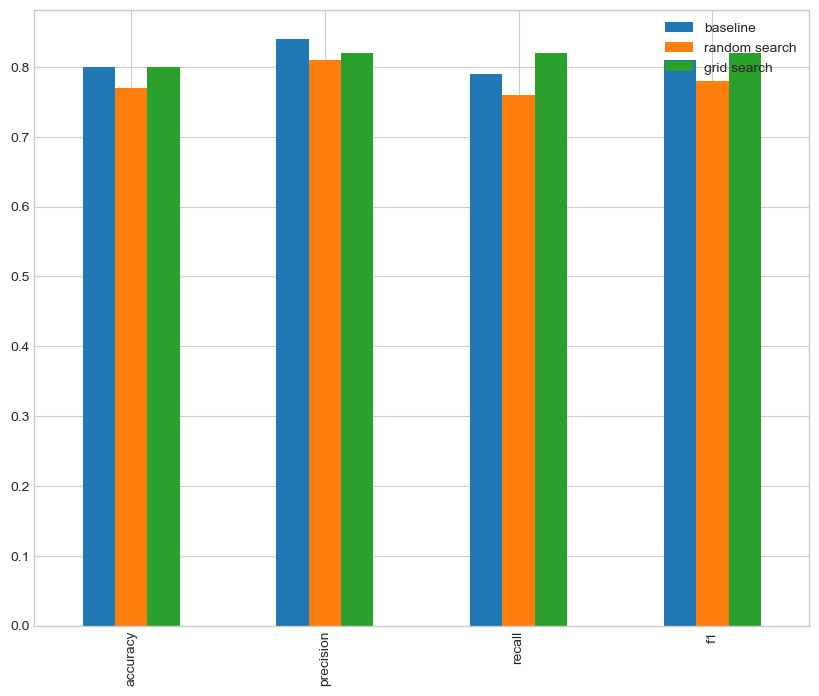

In [12]:
plt.style.use('seaborn-v0_8-whitegrid')
compare_metrics = pd.DataFrame({"baseline": baseline_metrics,
                                "random search": rs_metrics,
                                "grid search": gs_metrics})

compare_metrics.plot.bar(figsize=(10, 8));